In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
#from scipy.interpolate import interp2d
from sklearn.pipeline import Pipeline
import seaborn as sns
plt.style.use('seaborn')

from cicyutils import CicyPad

In [2]:
# Load the dataset and select only the matrix entries and h11, h21 entries
cicy=pd.read_hdf('cicydata/cicy3f.h5')
cicy=cicy[['matrix','h11','h21']]

upsampled_w, upsampled_h = 18,18

In [3]:
matrixpad = CicyPad(upsampled_w=upsampled_w,upsampled_h=upsampled_h,ravel=True)

cicypad = matrixpad.fit_transform(cicy['matrix'])

# K-means Clustering Analysis

In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

The optimal value of $k$ is fixed by looking at the curves for inertia and silhouette score.

There should be an elbox in the inertia at the optimal $k$

There should be a fall-off in the silhouette score at the optimal $k$

In [5]:
inertia,sil_score = [],[]
num_clusters = range(2,30)
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    y_pred=kmeans.fit_transform(cicypad)
    inertia.append(kmeans.inertia_)
    sil_score.append(silhouette_score(cicypad,kmeans.labels_))

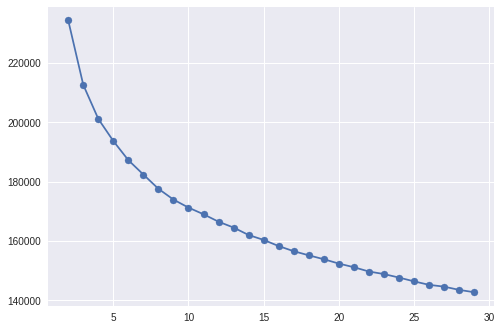

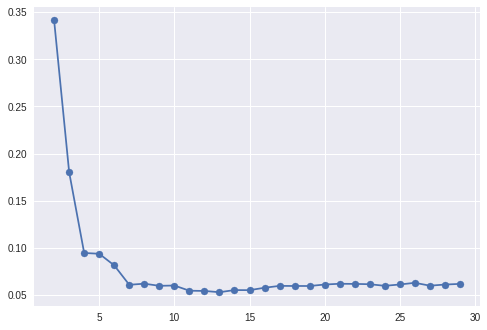

In [6]:
plt.plot(num_clusters,inertia)
plt.scatter(num_clusters,inertia)
plt.grid('both')
plt.show()
plt.plot(num_clusters,sil_score)
plt.scatter(num_clusters,sil_score)
plt.grid('both')
plt.show()

The location of the elbow in the intertia score, along with the fall off in the silhouette score suggest that we could take k=5 for fitting the clusterer.

## Fitting the K-Means Clusterer at the optimal value of K

In [7]:
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(cicypad)

In [8]:
h11 = cicy['h11'].to_numpy()
h21 = cicy['h21'].to_numpy()

### Distribution of $h^{1,1}$ and $h^{2,1}$ values at each cluster

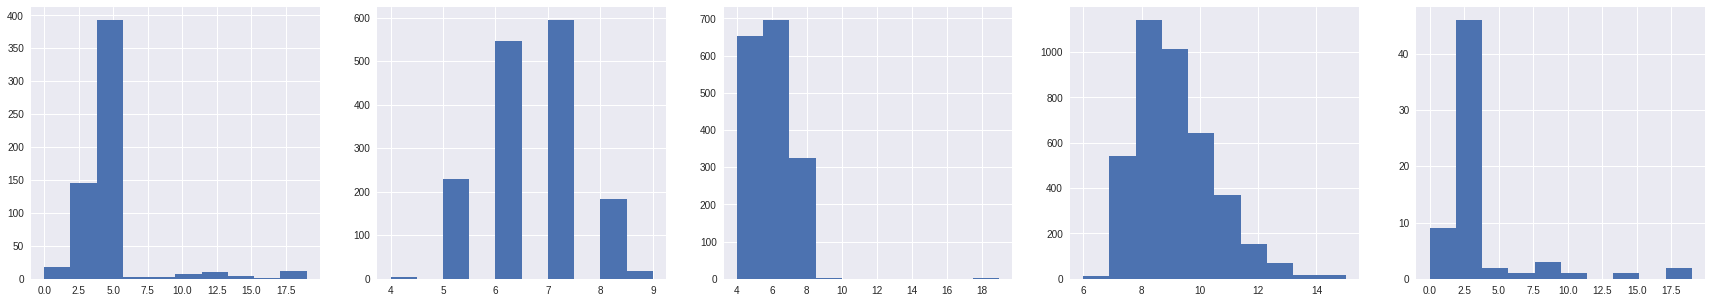

In [9]:
fig, axs = plt.subplots(1,5,figsize=(30,5))
for j in range(5):
    axs[j].hist(h11[np.where(y_pred==j)])
    axs[j].grid('both')
    #axs[1][j].hist(h11[np.where(y_pred==j+5)])
    #axs[1][j].grid('both')

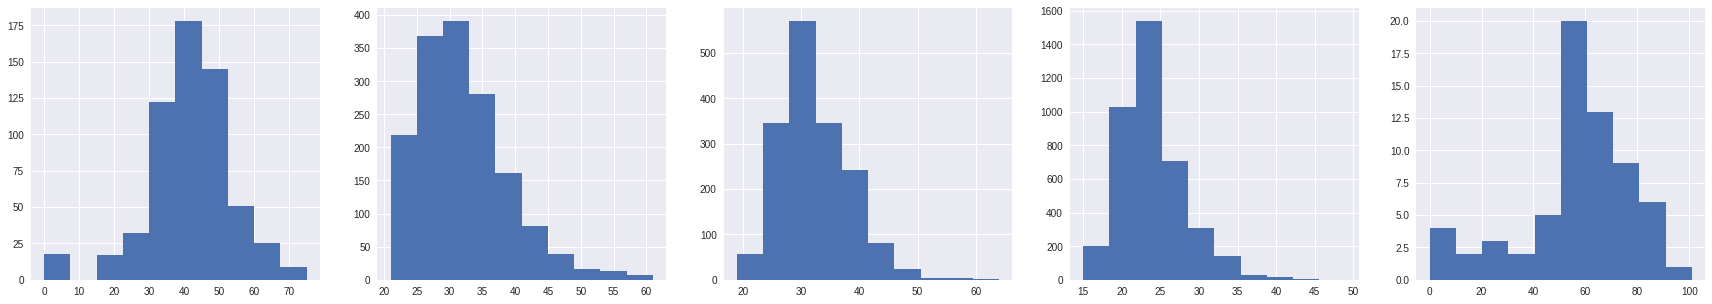

In [10]:
fig, axs = plt.subplots(1,5,figsize=(30,5))
for j in range(5):
    axs[j].hist(h21[np.where(y_pred==j)])
    axs[j].grid('both')

# Visualizing the configuration matrices as a scatter plot

In [11]:
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(cicypad)
X_2d.shape, pca.explained_variance_

((7890, 2), array([12.13634508,  2.39560977]))

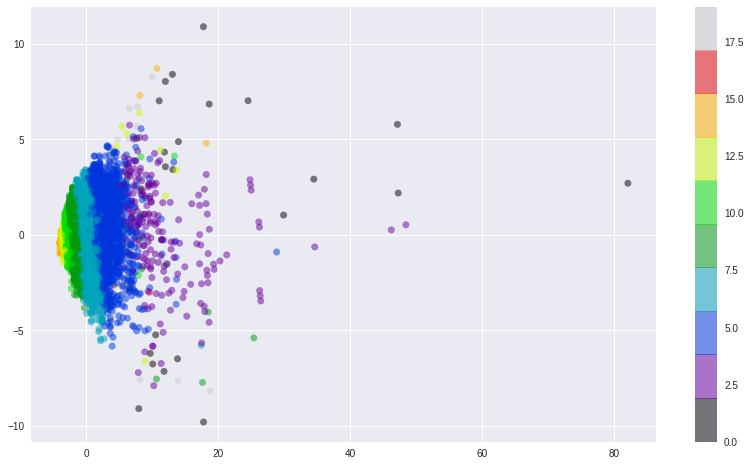

In [13]:
plt.figure(figsize=(14,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=h11,edgecolor='none',alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

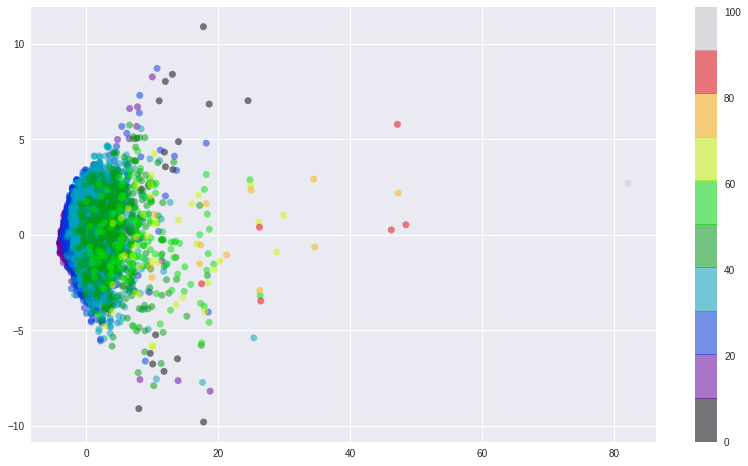

In [14]:
plt.figure(figsize=(14,8))
plt.scatter(X_2d[:,0],X_2d[:,1],c=h21,edgecolor='none',alpha=0.5,cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

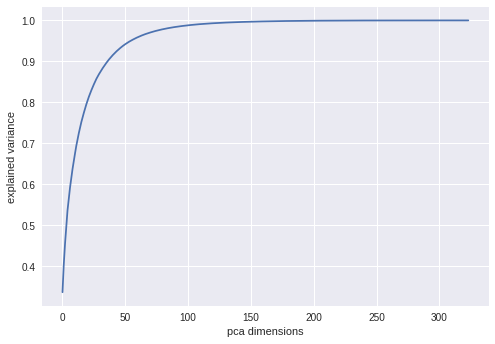

In [15]:
pca = PCA()
pca.fit(cicypad)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cumsum)),cumsum)
#plt.scatter(range(len(cumsum)),cumsum,s=20,c='red',alpha=0.5)
plt.xlabel('pca dimensions')
plt.ylabel('explained variance')
plt.show()

In [16]:
pca.explained_variance_ratio_[:10]

array([0.3369327 , 0.06650761, 0.05077195, 0.04193203, 0.04053024,
       0.02895434, 0.02669331, 0.02350286, 0.02190549, 0.01965808])

# Visualizing the Similarity Score

The scatterplots shown above already suggest that the data are somewhat grouped together by their $h^{1,1}$ values,
when represented as vectors.

One way of examining how well they are grouped is by computing the average length of the displacement vector between
data belonging to the $i$-th and $j$-th values of $h^{1,1}$. 

If the grouping is good, this average would be close to zero when $i=j$ and significantly away from zero when $i\neq j$.

In this case, one could infer that the data are organized into isolated clusters, each cluster being characterized by
a particular $h^{1,1}$ value.

In [17]:
embeddingdim=50

from itertools import product

def diffall(v1,v2,d=embeddingdim):
    return (v1-v2[:,np.newaxis]).reshape((-1,d))

def norm(v):
    return np.linalg.norm(v,axis=1)

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=embeddingdim)
X_2d = pca.fit_transform(cicypad)
X_2d.shape, np.sum(pca.explained_variance_ratio_)

((7890, 50), 0.9398955849965461)

In [19]:
nclass = len(np.unique(h11))
h11unique = np.unique(h11)
similarity = np.empty((nclass,nclass))
for (i,j) in  product(range(nclass),range(nclass)):
    xa = X_2d[np.where(h11==h11unique[i])[0]]
    xb = X_2d[np.where(h11==h11unique[j])[0]]
    similarity[i,j] = np.mean(norm(diffall(xa,xb)))

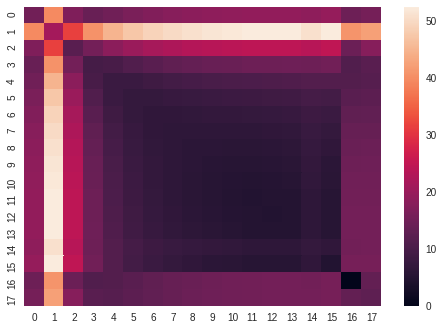

In [20]:
sns.heatmap(similarity)
plt.show()